Нейроконсультант по англоязычному сайту с ответами на вопросы по содержимому сайта на **русском** языке.

In [ ]:
!pip install nest_asyncio openai langchain langchain_openai cohere tiktoken faiss-cpu lxml bs4 html5lib xmltodict
!pip install newspaper3k

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import requests
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
import matplotlib.pyplot as plt
import os
from langchain.vectorstores import FAISS
from bs4 import BeautifulSoup
import pickle
from langchain.schema import Document

from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### Сайт https://www.immigrationspain.es/en/ - Immigration lawyers

In [ ]:
# !pip install newspaper3k
from newspaper import Article


# Спарсим из XML все ссылки на статьи и разделы и соберем
# отдельно название статей + отдельно содержание с помощью newspaper3k
def docs_from_xml_link(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "xml")
    loc_list = soup.find_all('loc')
    text_list = []
    for loc in loc_list:
        if '/en/' in loc.text: # Англоязычные страницы
            article = Article(loc.text)
            article.download()
            article.parse()
            title = f'{article.title}.'
            content = f'{article.text}'
            text_list.append([title, content])
    return text_list


urls = ['https://www.immigrationspain.es/post-sitemap.xml',
        'https://www.immigrationspain.es/page-sitemap.xml']

data_list = []
for url in urls:
    data_list.extend(docs_from_xml_link(url))

In [ ]:
print(len(data_list))
data_list[150]

201


['Unmarried Partners of EU Citizens Entering Spain to Join Them.',
 'What is this new measure about? Very simple.\n\nIt facilitates (and makes possible) entry into Spain for foreign couples of EU nationals who are yet unmarried and unregistered.\n\nAs we have already mentioned in other articles, through the family member of a European Union citizen immigration procedure, a foreigner from outside the EU can enter Spain and obtain residency, provided that he or she is married or in a civil union relationship with a community citizen.\n\nAnd this could be done by entering Spain as a tourist and legally formalizing the relationship afterwards. And without the need to leave the country.\n\nHowever, during the coronavirus health crisis, this is something that could not be done (temporarily).\n\nThat is, with the existing restrictions on entry into the country to contain the virus, the only foreigners who could enter Spain were legal residents with a residence permit. But in the case of not b

In [ ]:
# Сохранение в Колаб
with open("text_list.pickle", "wb") as f:
    pickle.dump(data_list, f)

with open("text_list.pickle", "rb") as f:
    text_list = pickle.load(f)

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens


docs_final = []
# Пороговое значение для количества токенов
threshold = 1000

# Перебираем каждую статью
for fragment in text_list:
    num_tokens = num_tokens_from_string(fragment[1], "cl100k_base")
    title = fragment[0]

    # Если статья превышает пороговое значение, разбиваем ее
    if num_tokens > threshold:
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=threshold,
                                                       chunk_overlap=50)
        text_parts = text_splitter.split_text(fragment[1])

        for text_part in text_parts:
            # Добавляем название статьи ко всем частям
            docs_final.append(Document(
                    page_content = title + '\n' + text_part,
                    metadata={'title': title}))
    else:
        # Если фрагмент не превышает порог
        docs_final.append(Document(
                    page_content = title + '\n' + fragment[1],
                    metadata={'title': title}))


print(len(docs_final))
docs_final[150]

201


Document(page_content='Unmarried Partners of EU Citizens Entering Spain to Join Them.\nWhat is this new measure about? Very simple.\n\nIt facilitates (and makes possible) entry into Spain for foreign couples of EU nationals who are yet unmarried and unregistered.\n\nAs we have already mentioned in other articles, through the family member of a European Union citizen immigration procedure, a foreigner from outside the EU can enter Spain and obtain residency, provided that he or she is married or in a civil union relationship with a community citizen.\n\nAnd this could be done by entering Spain as a tourist and legally formalizing the relationship afterwards. And without the need to leave the country.\n\nHowever, during the coronavirus health crisis, this is something that could not be done (temporarily).\n\nThat is, with the existing restrictions on entry into the country to contain the virus, the only foreigners who could enter Spain were legal residents with a residence permit. But in

In [ ]:
# Сохранение docs_final в Колаб
with open("docs_final.pickle", "wb") as f:
    pickle.dump(docs_final, f)

with open("docs_final.pickle", "rb") as f:
    docs_final = pickle.load(f)

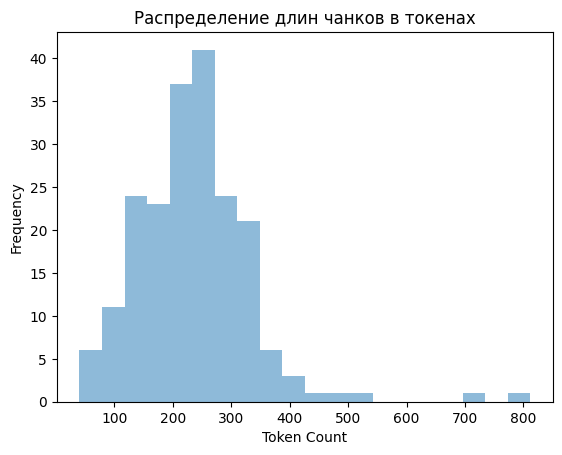

In [ ]:
# Подсчет токенов для каждого документа и построение графика
fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in docs_final]
plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Docs')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()
# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(docs_final, embeddings)

In [ ]:
# Сохранение базы в Колаб
index_name = "db_migrat"
db.save_local(folder_path='',
              index_name=index_name)

db = FAISS.load_local(folder_path='',
                      embeddings=embeddings,
                      index_name=index_name)
len(db.docstore._dict)

201

In [ ]:
# Функция для перевода вопроса пользователя на Английский
# для эффективного поиска близких чанков в индексной базе

# !pip install translate
from translate import Translator

translator = Translator(from_lang="ru", to_lang="en")
def my_translate(text):
    return translator.translate(text)

txt = 'Одна из Форм получения вида на жительство в Испании осуществляется через программу ЗОЛОТАЯ ВИЗА'
my_translate(txt)

'One of the Forms of obtaining a residence permit in Spain is carried out through the GOLDEN VISA PROGRAM'

In [ ]:
def scores(query, db):
    docs_and_scores = db.similarity_search_with_score(query, k=4)
    print('Scores:', [doc[1] for doc in docs_and_scores])

# Вопрос с переводом на Английский
en_text = my_translate('Неженатые партнеры граждан ЕС, въезжающих в Испанию')
print(en_text)
scores(en_text, db)

Unmarried partners of EU citizens entering Spain
Scores: [0.17998268, 0.23055384, 0.26118708, 0.26159304]


In [ ]:
# Без перевода на Английский
scores('Неженатые партнеры граждан ЕС, въезжающих в Испанию', db)

Scores: [0.3717001, 0.38703662, 0.42296493, 0.42569298]


In [ ]:
from langchain.chains import RetrievalQA
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate

In [ ]:
prompt_template = """Use the following sections of text to answer the question.
If there is no answer in the segments, just answer that you don't know, don't come up
with an answer from yourself. You can only take information from sections of text.
{context}
Question: {question}
Answer in Russian. You must answer only in Russian!:"""

PROMPT = PromptTemplate(
         template=prompt_template, input_variables=["context", "question"])

qa = RetrievalQA.from_chain_type(# llm=ChatOpenAI(model_name="gpt-3.5-turbo-0125", temperature=0.5, max_tokens=750)
                                 llm=OpenAI(temperature=0.3,
                                            max_tokens=2000),
                                 retriever=db.as_retriever(# search_type="similarity",
                                                           search_type="mmr",
                                                           # search_type="similarity_score_threshold",
                                                           search_kwargs={# 'score_threshold': 0.7,
                                                                          'k': 5,
                                                                          'lambda_mult': 0.25}), # 0 - max. разнообразие
                                 chain_type_kwargs={"prompt": PROMPT})

In [ ]:
en_text = my_translate('Расскажи о программе ЗОЛОТАЯ ВИЗА для получения вида на жительство')
qa.invoke(en_text)

{'query': 'Tell us about the GOLDEN VISA program for obtaining a residence permit',
 'result': '\n\nПрограмма GOLDEN VISA предназначена для получения разрешения на проживание в Испании для инвесторов. Первоначальная карта инвестора действительна в течение 2 лет, после чего необходимо ее продлить. Однако, после первого продления, карта будет действительна еще на 5 лет, что позволяет избежать частых продлений и бюрократических процедур. Для получения этой визы необходимо начать процесс продления в определенный период времени - за 60 дней до и 90 дней после истечения срока действия карты. Также существует альтернативный вариант получения разрешения на проживание - через брак или гражданское партнерство с гражданином Евросоюза. В этом случае, процесс получения визы будет проще и быстрее.'}

In [ ]:
en_text = my_translate('Расскажи о разрешении на проживание для Неженатых партнеров граждан ЕС, въезжающих в Испанию')
qa.invoke(en_text)

{'query': 'Tell us about the residence permit for Unmarried Partners of EU citizens entering Spain',
 'result': '\n\nРазрешение на проживание в Испании для неженатых стабильных пар граждан ЕС является одним из основных способов получения резиденции в Испании для иностранцев. Это разрешение известно как "член семьи гражданина ЕС" и предоставляет право на проживание и работу на 5 лет для любого гражданина не из ЕС, который является родственником гражданина ЕС. Однако есть ограничения - например, дяди и внуки не подпадают под этот тип разрешения. Но пары, состоящие в браке или зарегистрировавшие гражданский брак с гражданином ЕС, могут получить разрешение на проживание по этому пути. Главное требование - это правильная регистрация брака или брака в Испании. Если это не так, то существует третий вариант - получение разрешения на проживание по особым обстоятельствам для стабильных незарегистрированных пар. Для этого необходимо обратиться к иммиграционным юристам и получить персонализированн